### Remove Background

In [12]:
import os
import cv2
import numpy as np

def process_leaf_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    morph_img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations=3)
    _, thresh_img = cv2.threshold(morph_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        if largest_contour.shape[0] >= 5:
            ellipse = cv2.fitEllipse(largest_contour)
            mask = np.zeros_like(img)
            cv2.ellipse(mask, ellipse, (255, 255, 255), -1)
            dilated_mask = cv2.dilate(mask, kernel, iterations=3)
            img_masked = cv2.bitwise_and(img, dilated_mask)
            return img_masked
    return img  # Return original if processing is not applicable

def process_subfolders(base_folder):
    # List all subdirectories in the base folder
    subdirectories = [d for d in os.listdir(base_folder) if os.path.isdir(os.path.join(base_folder, d))]
    for subdir in subdirectories:
        if subdir == 'backup':
            continue
        subdir_path = os.path.join(base_folder, subdir)
        # if "2023-09-28_3_30_45_uv_Photo_Capture" in subdir_path:
        print(subdir_path)
        # Process each file in the subdir 
        for file in os.listdir(subdir_path):
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(subdir_path, file)
                processed_image = process_leaf_image(image_path)
                processed_image_path = os.path.join(subdir_path, f"processed_{file}")
                cv2.imwrite(processed_image_path, processed_image)
        print(f"Processed - {subdir}")

# Define the base folder path
base_folder = "ecoli Citrus"  # Update this path to your actual folder path

# Process the images in subfolders
process_subfolders(base_folder)

ecoli Citrus\2023-09-28_3_30_45_uv_Photo_Capture
Processed - 2023-09-28_3_30_45_uv_Photo_Capture


### Comparision Images 

In [45]:
import os
import cv2
import numpy as np

def resize_image_to_same_height(img, height):
    """Resize an image to the given height while maintaining aspect ratio."""
    ratio = height / img.shape[0]
    width = int(img.shape[1] * ratio)
    resized_img = cv2.resize(img, (width, height), interpolation=cv2.INTER_AREA)
    return resized_img

def create_comparison_for_all_images(subdir_path, subdir_name):
    original_images = []
    processed_images = []

    for file in os.listdir(subdir_path):
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            if file.startswith('processed_'):
                processed_path = os.path.join(subdir_path, file)
                processed_img = cv2.imread(processed_path, cv2.IMREAD_GRAYSCALE)
                processed_images.append(processed_img)
            else:
                original_path = os.path.join(subdir_path, file)
                original_img = cv2.imread(original_path, cv2.IMREAD_GRAYSCALE)
                original_images.append(original_img)

    # Ensure all images are the same height for comparison
    max_height = max(img.shape[0] for img in original_images + processed_images)
    original_images = [resize_image_to_same_height(img, max_height) for img in original_images]
    processed_images = [resize_image_to_same_height(img, max_height) for img in processed_images]

    # Concatenate all original images horizontally and all processed images horizontally
    concatenated_originals = np.hstack(original_images) if original_images else None
    concatenated_processeds = np.hstack(processed_images) if processed_images else None

    # Concatenate the two sets of images vertically
    if concatenated_originals is not None and concatenated_processeds is not None:
        comparison_img = np.vstack((concatenated_originals, concatenated_processeds))
        comparison_path = os.path.join(subdir_path, f"comparison_{subdir_name}.png")
        cv2.imwrite(comparison_path, comparison_img)
        print(f"Comparison image created for {subdir_name}")

def create_comparison_for_subfolders(base_folder):
    subdirectories = [d for d in os.listdir(base_folder) if os.path.isdir(os.path.join(base_folder, d))]
    for subdir in subdirectories:
        if subdir == 'backup':
            continue
        subdir_path = os.path.join(base_folder, subdir)
        create_comparison_for_all_images(subdir_path, subdir)

# Define the base folder path
base_folder = "ecoli Citrus"  # Update this path to your actual folder path

# Create comparison images for subfolders
create_comparison_for_subfolders(base_folder)


Comparison image created for 2023-09-28_3_19_42_uv_Photo_Capture
Comparison image created for 2023-09-28_4_27_29_uv_Photo_Capture
Comparison image created for 2023-09-28_4_30_13_uv_Photo_Capture
Comparison image created for 2023-09-28_4_33_18_uv_Photo_Capture
Comparison image created for 2023-09-28_4_37_08_uv_Photo_Capture
Comparison image created for 2023-09-28_4_39_21_uv_Photo_Capture
Comparison image created for 2023-09-28_4_41_43_uv_Photo_Capture
Comparison image created for 2023-09-28_4_44_31_uv_Photo_Capture


### PyWavelets

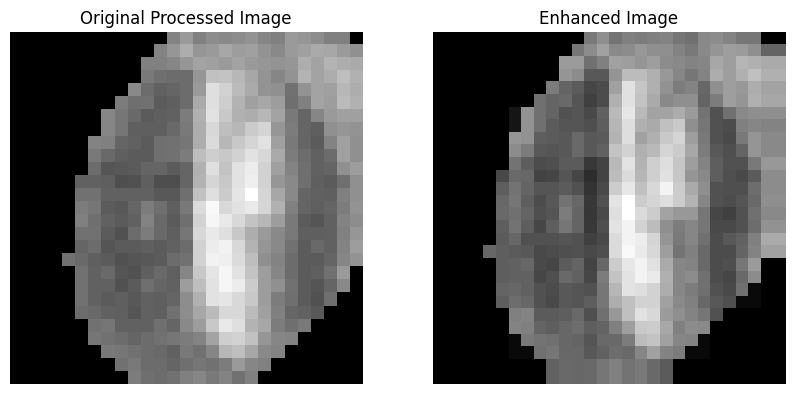

In [6]:
import pywt
import numpy as np
import cv2
import matplotlib.pyplot as plt

def enhance_image_with_wavelets(image_path):
    # Load the image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Perform a 2-level wavelet decomposition
    coeffs = pywt.wavedec2(img, 'db1', level=2)
    cA2, (cH2, cV2, cD2), (cH1, cV1, cD1) = coeffs
    
    # Enhance the detail coefficients (this is a simplistic approach; adjustments may be needed)
    cH2 *= 1.5
    cV2 *= 1.5
    cD2 *= 1.5
    
    # Reconstruct the image from the modified coefficients
    coeffs = cA2, (cH2, cV2, cD2), (cH1, cV1, cD1)
    enhanced_img = pywt.waverec2(coeffs, 'db1')
    
    # Ensure the enhanced image has the same scale as the original
    enhanced_img = np.clip(enhanced_img, 0, 255).astype(np.uint8)
    
    return enhanced_img

# Example usage
image_path = 'ecoli Citrus/2023-09-28_4_30_13_uv_Photo_Capture/processed_2023-09-28_4_30_13_uv_Photo_Capture_1.png'  # Update with the actual path
enhanced_img = enhance_image_with_wavelets(image_path)

# Display the original and enhanced images side by side
original_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(original_img, cmap='gray')
ax[0].set_title('Original Processed Image')
ax[1].imshow(enhanced_img, cmap='gray')
ax[1].set_title('Enhanced Image')
for a in ax:
    a.axis('off')
plt.show()


### Clear Comparision and Processed images

In [43]:
import os

def clear_processed_and_comparison_images(base_folder):
    for subdir, _, files in os.walk(base_folder):
        for file in files:
            if file.startswith("processed_") or file.startswith("comparison_"):
                # Construct the full path to the file
                file_path = os.path.join(subdir, file)
                # Remove the file
                os.remove(file_path)
                print(f"Removed {file_path}")

# Define the base folder path
base_folder = "ecoli Citrus"  # Replace with your actual base folder path

# Run the function to clear the images
clear_processed_and_comparison_images(base_folder)


Removed ecoli Citrus\2023-09-28_3_19_42_uv_Photo_Capture\comparison_2023-09-28_3_19_42_uv_Photo_Capture.png
Removed ecoli Citrus\2023-09-28_3_19_42_uv_Photo_Capture\processed_2023-09-28_3_19_42_uv_Photo_Capture_1.png
Removed ecoli Citrus\2023-09-28_3_19_42_uv_Photo_Capture\processed_2023-09-28_3_19_42_uv_Photo_Capture_2.png
Removed ecoli Citrus\2023-09-28_3_19_42_uv_Photo_Capture\processed_2023-09-28_3_19_42_uv_Photo_Capture_3.png
Removed ecoli Citrus\2023-09-28_3_19_42_uv_Photo_Capture\processed_2023-09-28_3_19_42_uv_Photo_Capture_4.png
Removed ecoli Citrus\2023-09-28_4_27_29_uv_Photo_Capture\comparison_2023-09-28_4_27_29_uv_Photo_Capture.png
Removed ecoli Citrus\2023-09-28_4_27_29_uv_Photo_Capture\processed_2023-09-28_4_27_29_uv_Photo_Capture_1.png
Removed ecoli Citrus\2023-09-28_4_27_29_uv_Photo_Capture\processed_2023-09-28_4_27_29_uv_Photo_Capture_2.png
Removed ecoli Citrus\2023-09-28_4_27_29_uv_Photo_Capture\processed_2023-09-28_4_27_29_uv_Photo_Capture_3.png
Removed ecoli Citrus\

### Rotation Test

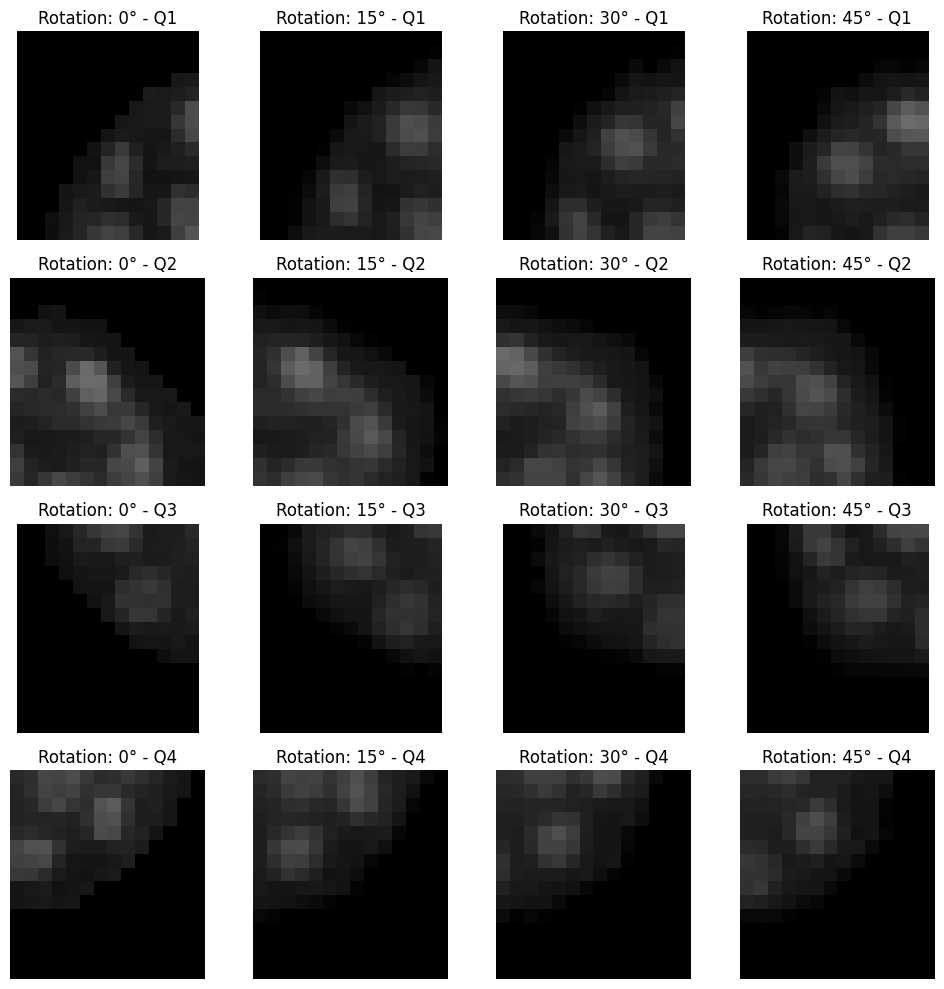

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load the image
# img_path = 'C:\\Users\\vsneh\\Downloads\\test.png'
img_path = 'C:\\Users\\vsneh\\Udemy-notebooks\\OPS Ecoli\\ecoli Citrus\\2023-09-28_3_19_42_uv_Photo_Capture\\processed_2023-09-28_3_19_42_uv_Photo_Capture_1.png'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for visualization in Matplotlib

# Function to rotate image
def rotate_image(image, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result

# Function to extract quadrants from the image
def extract_quadrants(image):
    height, width = image.shape[:2]
    center = (width // 2, height // 2)

    quadrants = []
    quadrants.append(image[:center[1], :center[0]])  # Top-Left
    quadrants.append(image[:center[1], center[0]:])  # Top-Right
    quadrants.append(image[center[1]:, :center[0]])  # Bottom-Left
    quadrants.append(image[center[1]:, center[0]:])  # Bottom-Right
    return quadrants

# Prepare to plot
fig, axs = plt.subplots(4, 4, figsize=(10, 10))

# Process and display the quadrants for each rotation increment
for i in range(4):  # For 0, 10, 20, 30 degrees
    angle = i * 15
    rotated_img = rotate_image(img, angle)
    quadrants = extract_quadrants(rotated_img)
    
    for j, quadrant in enumerate(quadrants):
        axs[j, i].imshow(quadrant)
        axs[j, i].set_title(f"Rotation: {angle}° - Q{j+1}")
        axs[j, i].axis('off')

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
#### Process and Save Rotated Images
def process_and_save_images(base_dir):
    for class_name in os.listdir(base_dir):
        class_dir = os.path.join(base_dir, class_name)
        if not ("Capture" in class_name and os.path.isdir(os.path.join(base_dir, class_name))):
            continue

        rotated_dir = os.path.join(class_dir, "rotated")
        os.makedirs(rotated_dir, exist_ok=True)
        
        for image_name in os.listdir(class_dir):
            # Check for the 'processed' prefix and image file extension
            if image_name.startswith("processed") and image_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(class_dir, image_name)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                quadrants = extract_quadrants(img)
                
                
                for i, quadrant in enumerate(quadrants):
                    for angle in [0, 10, 20, 30]:
                        rotated_quadrant = rotate_image(quadrant, angle)
                        # Name the file according to the rotation and quadrant
                        new_image_name = f"rotated/rotated_{angle}deg_Q{i+1}_{image_name.replace('processed_', '').replace('.png', '')}.png"
                        cv2.imwrite(os.path.join(rotated_dir, new_image_name), rotated_quadrant)
                print(image_name)

# Set the base directory
base_dir = "ecoli Citrus"
# Run the function
process_and_save_images(base_dir)

### Rough - (Renaming)

In [5]:
import os

# Define the base directory where the class directories are located
base_dir = "ecoli Citrus"

# Function to rename files in a directory
def rename_files(directory):
    for filename in os.listdir(directory):
        # Check for the 'Â°' character in filenames
        if "Â°" in filename:
            # Replace 'Â°' with 'deg' in the filename
            new_filename = filename.replace("Â°", "deg")
            new_filename = new_filename[:-4]
            # Define the complete filepath
            old_file_path = os.path.join(directory, filename)
            new_file_path = os.path.join(directory, new_filename)
            print(new_file_path)
            # Rename the file
            os.rename(old_file_path, new_file_path)

# Iterate over each class directory to access the 'rotated' subdirectory
for class_name in os.listdir(base_dir):
    # Skip if it's not a directory or doesn't contain 'Capture'
    class_dir = os.path.join(base_dir, class_name)
    if "Capture" in class_name and os.path.isdir(class_dir):
        rotated_dir = os.path.join(class_dir, "rotated")
        # Check if the 'rotated' directory exists
        if os.path.isdir(rotated_dir):
            # Rename the files in the 'rotated' directory
            rename_files(rotated_dir)
            
# # Output to check if the renaming was successful
# # List some of the files to confirm changes
# for root, dirs, files in os.walk(base_dir):
#     for file in files:
#         if "deg" in file:
#             print(os.path.join(root, file))
#             break  # Just print one file for checking



ecoli Citrus\2023-09-28_3_19_42_uv_Photo_Capture\rotated\rotated_0deg_Q1_2023-09-28_3_19_42_uv_Photo_Capture_3.png
ecoli Citrus\2023-09-28_3_19_42_uv_Photo_Capture\rotated\rotated_0deg_Q1_2023-09-28_3_19_42_uv_Photo_Capture_4.png
ecoli Citrus\2023-09-28_3_19_42_uv_Photo_Capture\rotated\rotated_0deg_Q2_2023-09-28_3_19_42_uv_Photo_Capture_1.png
ecoli Citrus\2023-09-28_3_19_42_uv_Photo_Capture\rotated\rotated_0deg_Q2_2023-09-28_3_19_42_uv_Photo_Capture_2.png
ecoli Citrus\2023-09-28_3_19_42_uv_Photo_Capture\rotated\rotated_0deg_Q2_2023-09-28_3_19_42_uv_Photo_Capture_3.png
ecoli Citrus\2023-09-28_3_19_42_uv_Photo_Capture\rotated\rotated_0deg_Q2_2023-09-28_3_19_42_uv_Photo_Capture_4.png
ecoli Citrus\2023-09-28_3_19_42_uv_Photo_Capture\rotated\rotated_0deg_Q3_2023-09-28_3_19_42_uv_Photo_Capture_1.png
ecoli Citrus\2023-09-28_3_19_42_uv_Photo_Capture\rotated\rotated_0deg_Q3_2023-09-28_3_19_42_uv_Photo_Capture_2.png
ecoli Citrus\2023-09-28_3_19_42_uv_Photo_Capture\rotated\rotated_0deg_Q3_2023-09